In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import csv
file_path = 'zombies_data.csv'
speeds = []
ammos = []
labels = []

with open(file_path, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for row in reader:
        if not row:
            continue
        speed = float(row[0])
        ammo = float(row[1])
        label = int(row[2])
        speeds.append(speed)
        ammos.append(ammo)
        labels.append(label)

speeds = np.array(speeds)
ammos = np.array(ammos)
labels = np.array(labels)

In [3]:
# Prepare feature matrix X and label vector y
X_original = np.column_stack((speeds, ammos)) 
y = labels.reshape(-1, 1)

m, n = X_original.shape
print('Number of examples (m):', m)
print('Number of features (n):', n)

# Feature normalization: x_norm = (x - mean) / std
mu = np.mean(X_original, axis=0)
sigma = np.std(X_original, axis=0, ddof=0)

X_norm = (X_original - mu) / sigma

print('Feature means:', mu)
print('Feature std devs:', sigma)

# Add intercept term (column of ones) to get X of shape (m, n+1)
X = np.hstack((np.ones((m, 1)), X_norm))
print('Shape of X (with bias):', X.shape)
print('Shape of y:', y.shape)

Number of examples (m): 22
Number of features (n): 2
Feature means: [16.43181818  2.09090909]
Feature std devs: [5.66748191 1.75574617]
Shape of X (with bias): (22, 3)
Shape of y: (22, 1)


In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_cost(theta, X, y):
    m = len(y)
    z = X @ theta
    h = sigmoid(z)
    
    # Avoid log(0) by clipping values
    eps = 1e-15
    h_clipped = np.clip(h, eps, 1 - eps)
    
    J = (-1 / m) * (y.T @ np.log(h_clipped) + (1 - y).T @ np.log(1 - h_clipped))
    return J.flatten()[0]


def compute_gradient(theta, X, y):
    # gradient of the cost w.r.t. theta
    m = len(y)
    z = X @ theta
    h = sigmoid(z)
    grad = (1 / m) * (X.T @ (h - y))
    return grad

In [5]:
# Train using Gradient Descent

theta = np.zeros((X.shape[1], 1))  # (n+1, 1)

alpha = 0.1
num_iters = 2000 

J_history = []

for i in range(num_iters):
    grad = compute_gradient(theta, X, y)
    theta = theta - alpha * grad
    J = compute_cost(theta, X, y)
    J_history.append(J)
    

print('\nFinal theta (parameters):')
print(theta.ravel())


Final theta (parameters):
[1.28369474 5.96055882 4.34206947]


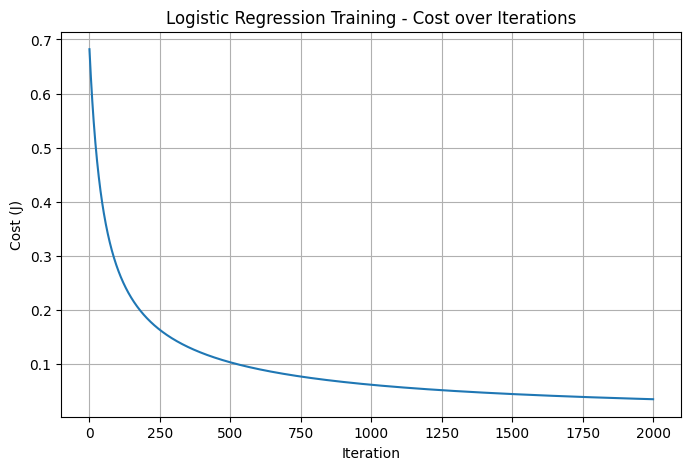

In [6]:
# Visualize the cost dropping over iterations

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_iters + 1), J_history)
plt.xlabel('Iteration')
plt.ylabel('Cost (J)')
plt.title('Logistic Regression Training - Cost over Iterations')
plt.grid(True)
plt.show()

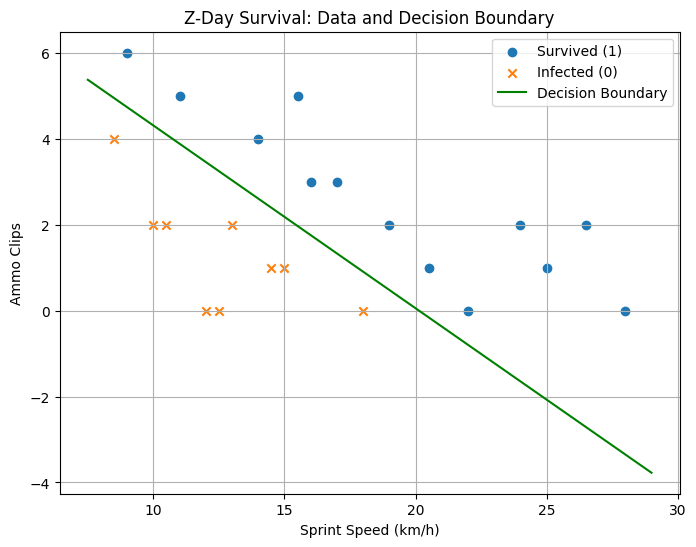

In [7]:
# Plot the decision boundary in original feature space


survived = (y.ravel() == 1)
infected = (y.ravel() == 0)

plt.figure(figsize=(8, 6))

plt.scatter(X_original[survived, 0], X_original[survived, 1], marker='o', label='Survived (1)')
plt.scatter(X_original[infected, 0], X_original[infected, 1], marker='x', label='Infected (0)')

# Decision boundary:
# Our model is: z = theta0 + theta1 * x1_norm + theta2 * x2_norm = 0
# where xj_norm = (xj - mu_j) / sigma_j
# So: theta0 + theta1 * (x1 - mu1)/s1 + theta2 * (x2 - mu2)/s2 = 0
# Solve for x2 in terms of x1:
# x2 = mu2 + (s2 / theta2) * ( -theta0 - theta1 * (x1 - mu1) / s1 )

theta0 = theta[0, 0]
theta1 = theta[1, 0]
theta2 = theta[2, 0]

# Create a range of SprintSpeed values in original scale
x1_vals = np.linspace(X_original[:, 0].min() - 1, X_original[:, 0].max() + 1, 100)

# Compute corresponding AmmoClips (x2) on the decision boundary
# Guard against theta2 == 0
if abs(theta2) < 1e-8:
    print('Warning: theta2 is very close to 0; decision boundary may be almost vertical.')
else:
    mu1, mu2 = mu[0], mu[1]
    s1, s2 = sigma[0], sigma[1]
    
    x2_vals = mu2 + (s2 / theta2) * ( -theta0 - theta1 * (x1_vals - mu1) / s1 )
    
    plt.plot(x1_vals, x2_vals, 'g-', label='Decision Boundary')

plt.xlabel('Sprint Speed (km/h)')
plt.ylabel('Ammo Clips')
plt.title('Z-Day Survival: Data and Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Test prediction: Runner with 25 km/h speed and 1 ammo clip

def predict_proba(features, theta, mu, sigma):
    features = np.array(features, dtype=float)
    
    # Normalize using training set mean and std
    features_norm = (features - mu) / sigma
    
    # Add bias term
    x_input = np.hstack(([1.0], features_norm))
    
    z = x_input @ theta
    prob = sigmoid(z)
    return float(prob)


test_runner = [25, 1]  # 25 km/h, 1 ammo clip
prob_survival = predict_proba(test_runner, theta, mu, sigma)
prediction = 1 if prob_survival >= 0.5 else 0

print(f'Test Runner: Speed = {test_runner[0]} km/h, Ammo Clips = {test_runner[1]}')
print(f'Predicted survival probability: {prob_survival:.4f}')
print(f'Predicted class (1 = Survive, 0 = Infected): {prediction}')

Test Runner: Speed = 25 km/h, Ammo Clips = 1
Predicted survival probability: 0.9995
Predicted class (1 = Survive, 0 = Infected): 1


/var/folders/84/qv7bch1j49b04xmbq_q_6ppw0000gn/T/ipykernel_69379/1196990754.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(prob)
